In [1]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

normalize = transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))

transform_original = transform.Compose([
transform.Resize((224, 224)),
transform.ToTensor(), 
normalize,
])

transform_augmentation = transform.Compose([
transform.Resize((224, 224)),
transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
transform.RandomRotation(5),
transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
transform.ToTensor(),
transform.RandomErasing(inplace=True, scale=(0.01, 0.23)),
normalize,
])

train = ImageFolder(os.path.join('splitted','train'), transform=transform_augmentation)
val = ImageFolder(os.path.join('splitted','train'), transform=transform_original)
loaders = {'train':DataLoader(train, batch_size=64, num_workers=4, pin_memory=True, shuffle=True),
           'val':DataLoader(val, batch_size=64, num_workers=4, pin_memory=True, shuffle=True),}
dataset_sizes = {'train':len(train),'val':len(val)}


In [2]:

def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1) 
        return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

class TransferLearningImageClassification:
    def __init__(self, loaders, dataset_sizes):
        self.epochs = 10
        self.criterion = nn.CrossEntropyLoss()
        self.losses = {'train': [], 'val': []}
        self.accuracies = {'train': [], 'val': []}
        self.lr = []
        self.best_acc = 0.0
        self.loaders = loaders
        self.dataset_sizes = dataset_sizes

    def train(self, model, device, parameters, optimizer, scheduler):
        since = time.time()
        best_model = copy.deepcopy(model.state_dict())
        for epoch in range(self.epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0.0

                for inputs, labels in self.loaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outp = model(inputs)
                        _, pred = torch.max(outp, 1)
                        loss = self.criterion(outp, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(pred == labels.data)

                if phase == 'train':
                    acc = 100. * running_corrects.double() / self.dataset_sizes[phase]
                    scheduler.step(acc)

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double() / self.dataset_sizes[phase]
                self.losses[phase].append(epoch_loss)
                self.accuracies[phase].append(epoch_acc)
                if phase == 'train':
                    print('Epoch: {}/{}'.format(epoch + 1, self.epochs))
                print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
                self.lr.append(scheduler._last_lr)

                if phase == 'val':
                    print('Time: {}m {}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
                    print('==' * 31)
                if phase == 'val' and epoch_acc > self.best_acc:
                    self.best_acc = epoch_acc
                    best_model = copy.deepcopy(model.state_dict())
            # scheduler.step()
        time_elapsed = time.time() - since
        print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('==' * 31)

        model.load_state_dict(best_model)
        return model


resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.grad_requires = False
resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(train.classes), bias=True)

# first round training: train only the last layer
model = resnet101
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
model.to(device)
classifier = TransferLearningImageClassification(loaders, dataset_sizes)
model = classifier.train(model, device, model.parameters(), optimizer, scheduler)

# fine tune all layers
for param in model.parameters():
        param.requires_grad=True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
model = classifier.train(model, device, model.parameters(), optimizer, scheduler)

PATH = './resnet_transfer.pth'
torch.save(model.state_dict(), PATH)


Epoch: 1/10
train - loss:1.0893290531137811, accuracy0.606646058732612
val - loss:0.8107526852321773, accuracy0.7399536321483771
Time: 0.0m 34.41030287742615s
Epoch: 2/10
train - loss:0.6882998436643315, accuracy0.7735703245749613
val - loss:0.8262238906008383, accuracy0.7569551777434312
Time: 1.0m 6.731651067733765s
Epoch: 3/10
train - loss:0.6083965473786757, accuracy0.7921174652241113
val - loss:0.7674364741471303, accuracy0.8025502318392581
Time: 1.0m 38.79622673988342s
Epoch: 4/10
train - loss:0.5766829716551248, accuracy0.7982998454404946
val - loss:0.8231696010188673, accuracy0.8037094281298299
Time: 2.0m 11.062239408493042s
Epoch: 5/10
train - loss:0.5095316585285771, accuracy0.8241885625965997
val - loss:0.9277148017374772, accuracy0.8346213292117465
Time: 2.0m 42.96418261528015s
Epoch: 6/10
train - loss:0.5152855119344072, accuracy0.8137557959814529
val - loss:0.8202146065797098, accuracy0.830370942812983
Time: 3.0m 15.108652830123901s
Epoch: 7/10
train - loss:0.4828908024283

In [4]:
def predict(model,x):
    out = model(x.to(device))
    _, preds = torch.max(out, dim=1)
    x.detach().cpu()
    return preds

test = ImageFolder(os.path.join('splitted','test'), transform=transform_original)
test_loader = DataLoader(test, batch_size=64, num_workers=4, pin_memory=True, shuffle=True)

labellst,predslst = [],[]
for x,y in test_loader:
    preds = predict(model,x)
    labellst.append(y.numpy())
    predslst.append(preds.detach().cpu().numpy())
    
labellst,predslst = np.hstack(labellst),np.hstack(predslst)

from sklearn.metrics import f1_score
f1_score(labellst,predslst,average='micro')

0.9470655926352128

<Figure size 640x480 with 0 Axes>

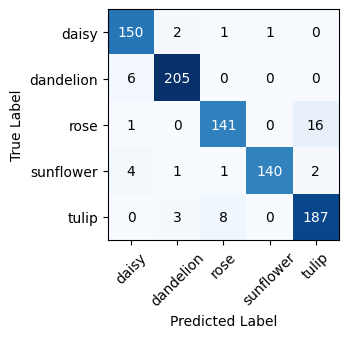

In [5]:
# Plot confusion matrix
cm  = confusion_matrix(labellst,predslst)
classes = test.classes
plt.figure()
plot_confusion_matrix(cm,figsize=(3,3),cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes,rotation=45)
plt.yticks(range(len(classes)), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()